In [3]:
# !pip install xgboost

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import joblib
import utils # contient toutes les fonctions crees pour le projet..


from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

### Importation des donnees


In [5]:
# ROOT = "/content/drive/Shareddrives/Canvas ECo energy/Eco Energy Energy Live Capstone/datasets/" # chemin sur colab
ROOT = "C:/Users/georg/OneDrive/Documents/GitHub/CapstoneProjectEnergy/Dataset/" # chemin en local


dred = "DRED.csv"
qud = "QUD.csv"
sim = "SimDataset.csv"


rw_dred = pd.read_csv(ROOT+dred, names= ["occupancy", "P", "Pn", "P+t1", "P-t1","class_state"], header=None)
rw_qud = pd.read_csv(ROOT+qud, names= ["occupancy", "P", "Pn", "P+t1", "P-t1","class_state"], header=None)
rw_sim = pd.read_csv(ROOT+sim, names= ['Occupancy' , 'Appliance_ID' , 'Sin(time)' , 'Cos(time)' , 'Sin(day)' , 'Cos(day)' , 'Power_consumption_P(t)' , 'Normalized-power-consumption ' , 'P(t)-P(t+1)' , 'P(t)-P(t-1)' , 'Micro-moment_class'], header=None)



In [6]:
print(rw_dred.shape)
rw_dred.head()

(166353, 6)


,occupancy,P,Pn,P+t1,P-t1,class_state
0,1,0.0,-0.68907,0.0,0.0,0
1,1,0.0,-0.68907,0.0,0.0,0
2,0,0.0,-0.68907,0.0,0.0,0
3,1,0.0,-0.68907,0.0,0.0,0
4,0,0.0,-0.68907,0.0,0.0,0


In [7]:
print(rw_qud.shape)
rw_qud.head()

(46930, 6)


,occupancy,P,Pn,P+t1,P-t1,class_state
0,1,0.00,-0.002259,0.00,0.00,0
1,1,0.00,-0.002259,-166.43,0.00,1
2,1,166.43,0.007632,0.00,166.43,3
3,1,159.55,0.007223,0.00,0.00,3
4,1,143.27,0.006255,0.00,0.00,3


## Machine Learning

In [8]:
# !pip install xgboost

#### Normalisation avec le coefficient de variance pour le ML

Qud

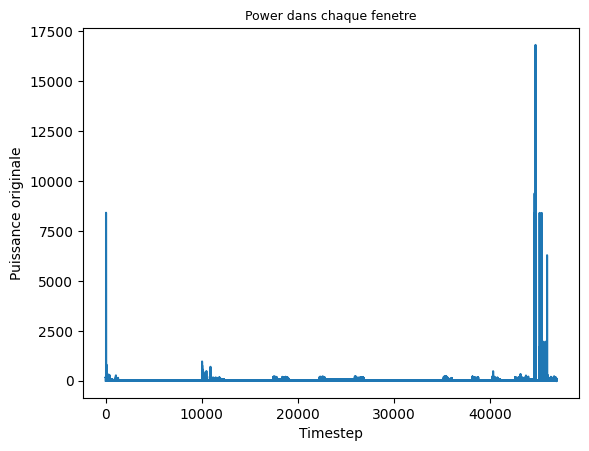

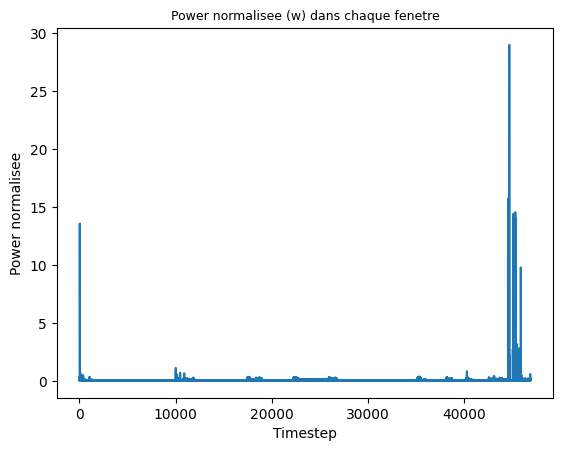

,oc1,oc2,oc3,p1,p2,p3,pt01,pt02,pt03,pt11,pt22,pt33,cl1,cl2,cl3,out,mean,std_window,norm_window
0,1.0,1.0,1.0,0.000000,0.000000,166.429993,0.000000,-166.429993,0.0,0.000000,0.000000,166.429993,0.0,1.0,3.0,3.0,55.476665,96.088402,0.288265
1,1.0,1.0,1.0,0.000000,166.429993,159.550003,-166.429993,0.000000,0.0,0.000000,166.429993,0.000000,1.0,3.0,3.0,3.0,108.659996,94.165176,0.144229
2,1.0,1.0,1.0,166.429993,159.550003,143.270004,0.000000,0.000000,0.0,166.429993,0.000000,0.000000,3.0,3.0,3.0,3.0,156.416672,11.893680,0.001761
3,1.0,1.0,1.0,159.550003,143.270004,175.880005,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.0,3.0,3.0,3.0,159.566666,16.305006,0.003332
4,1.0,1.0,1.0,143.270004,175.880005,176.660004,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.0,3.0,3.0,3.0,165.270004,19.056551,0.003850


In [9]:
rw_qud.shape , rw_qud.shape[0]-3
input_qud, output_qud = utils.slide_window(dataset=rw_qud ,window_size=3)
input_qud = input_qud.squeeze()

new_qud_dataset = np.concatenate((input_qud, np.expand_dims(output_qud, axis=-1)) , axis = 1)

df_qud = pd.DataFrame(new_qud_dataset, columns = ['oc1','oc2','oc3','p1','p2','p3','pt01','pt02','pt03' ,'pt11','pt22','pt33' ,'cl1','cl2','cl3', 'out' ] )

## normalisons avec le coefficient de variance

df_qud['mean'] = (df_qud['p1'] + df_qud['p2'] + df_qud['p3'] ) / 3 # moyenne des valeurs power pour une window
df_qud['std_window'] = df_qud[['p1' , 'p2' , 'p3']].std(axis=1) # std de P1, P2, P3
df_qud['norm_window'] = ( df_qud['std_window']/(df_qud['mean'] + 1e-7) ) * ((df_qud[['p1' , 'p2' , 'p3']].max(axis=1) - df_qud[['p1' , 'p2' , 'p3']].min(axis=1)) /1000) # normalization de P1, P2, P3 

## visualisation

debut = 0
fin   = -1

plt.plot(df_qud['p2'][debut:fin])
plt.xlabel('Timestep')
plt.ylabel("Puissance originale")
plt.title("Power dans chaque fenetre" , {'fontsize': 9}  )
plt.show()
print()

plt.plot(df_qud['norm_window'][debut:fin])
plt.xlabel('Timestep')
plt.ylabel("Power normalisee")
plt.title("Power normalisee (w) dans chaque fenetre" , {'fontsize': 9}  )
plt.show()
print()


df_qud.head()

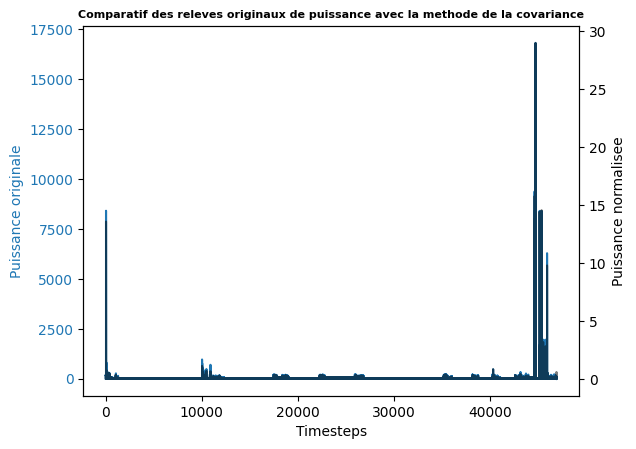

In [10]:
# visuel comparatif (superpose)

debut = 0
fin   = -1

# Creating plot with dataset_1
fig, ax1 = plt.subplots()
 
color = 'tab:blue'
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('Puissance originale', color = color)
ax1.plot(df_qud['p2'][debut:fin], color = color)
ax1.tick_params(axis ='y', labelcolor = color)
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
# color = 'tab:black'
ax2.set_ylabel('Puissance normalisee', color = 'black')
ax2.plot(df_qud['norm_window'][debut:fin], color = 'black' , alpha=0.5)
ax2.tick_params(axis ='y', labelcolor = 'black')
 
# Adding title
plt.title('Comparatif des releves originaux de puissance avec la methode de la covariance', fontsize = 8, fontweight ="bold")
 
# Show plot
plt.show()# Creating plot with dataset_1
 


In [11]:
# quelques statistiques

df_qud.describe()

,oc1,oc2,oc3,p1,p2,p3,pt01,pt02,pt03,pt11,pt22,pt33,cl1,cl2,cl3,out,mean,std_window,norm_window
count,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000,46927.000000
mean,0.305368,0.305368,0.305368,38.012348,38.014034,38.015625,0.201070,0.201070,0.204617,-0.201070,-0.201070,-0.201070,2.716773,2.716773,2.716752,2.716688,38.014004,9.364881,0.018141
std,0.460568,0.460568,0.460568,146.826355,146.826370,146.826355,41.879669,41.879669,41.872604,41.879669,41.879669,41.879669,1.731649,1.731649,1.731676,1.731721,101.581871,129.502716,0.335926
min,0.000000,0.000000,0.000000,-10.640000,-10.640000,-10.640000,-466.839996,-466.839996,-466.839996,-8399.900391,-8399.900391,-8399.900391,0.000000,0.000000,0.000000,0.000000,-4.716667,0.000000,-0.009791
25%,0.000000,0.000000,0.000000,15.770000,15.770000,15.770000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.766666,0.593745,0.000031
50%,0.000000,0.000000,0.000000,17.600000,17.600000,17.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,4.000000,4.000000,17.526667,0.990808,0.000085
75%,1.000000,1.000000,1.000000,41.820000,41.820000,41.825001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,4.000000,4.000000,41.610001,2.575643,0.000318
max,1.000000,1.000000,1.000000,16816.000000,16816.000000,16816.000000,8399.900391,8399.900391,8399.900391,466.839996,466.839996,466.839996,4.000000,4.000000,4.000000,4.000000,7237.319824,9691.935547,28.975348


,oc1,oc2,oc3,p1,p2,p3,pt01,pt02,pt03,pt11,pt22,pt33,cl1,cl2,cl3,out,mean,std_window,norm_window
oc1,1.000000,0.979405,0.958811,0.027165,0.026648,0.026697,-0.003455,-0.003739,-0.003440,0.003372,0.003455,0.003739,-0.898142,-0.879758,-0.861434,-0.843191,0.038790,0.022520,0.018716
oc2,0.979405,1.000000,0.979405,0.027024,0.027183,0.026664,-0.003372,-0.003455,-0.003612,0.003657,0.003372,0.003455,-0.879678,-0.898142,-0.879763,-0.861467,0.038964,0.022810,0.019019
oc3,0.958811,0.979405,1.000000,0.026901,0.027042,0.027199,-0.003657,-0.003372,-0.003328,0.003756,0.003657,0.003372,-0.861268,-0.879678,-0.898146,-0.879796,0.039094,0.023218,0.019450
p1,0.027165,0.027024,0.026901,1.000000,0.270919,0.112119,0.266103,0.018830,0.000414,0.019136,-0.266103,-0.018830,0.014420,0.007761,-0.003288,-0.003192,0.666347,0.545915,0.473515
p2,0.026648,0.027183,0.027042,0.270919,1.000000,0.270919,-0.019136,0.266103,0.018811,0.033614,0.019136,-0.266103,-0.003883,0.014402,0.007746,-0.003296,0.742857,0.644701,0.588579
p3,0.026697,0.026664,0.027199,0.112119,0.270919,1.000000,-0.033614,-0.019136,0.266126,0.000299,0.033614,0.019136,-0.010286,-0.003900,0.014388,0.007738,0.666347,0.711434,0.766439
pt01,-0.003455,-0.003372,-0.003657,0.266103,-0.019136,-0.033614,1.000000,-0.000023,-0.072227,0.000023,-1.000000,0.000023,0.032379,-0.015569,-0.035950,0.000829,0.102793,0.153259,0.184001
pt02,-0.003739,-0.003455,-0.003372,0.018830,0.266103,-0.019136,-0.000023,1.000000,-0.000023,0.072214,0.000023,-1.000000,0.017396,0.032379,-0.015569,-0.035949,0.128061,0.162607,0.180646
pt03,-0.003440,-0.003612,-0.003328,0.000414,0.018811,0.266126,-0.072227,-0.000023,1.000000,0.000045,0.072227,0.000023,0.003463,0.017266,0.032300,-0.015557,0.137482,0.150230,0.170125
pt11,0.003372,0.003657,0.003756,0.019136,0.033614,0.000299,0.000023,0.072214,0.000045,1.000000,-0.000023,-0.072214,0.015569,0.035950,-0.000829,-0.002938,0.025559,-0.002082,-0.006688


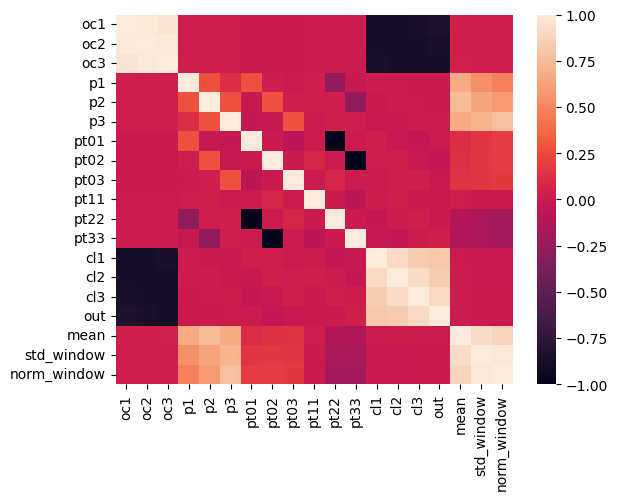

In [12]:
qud_corr = df_qud.corr()
sns.heatmap(qud_corr)
qud_corr

Dred

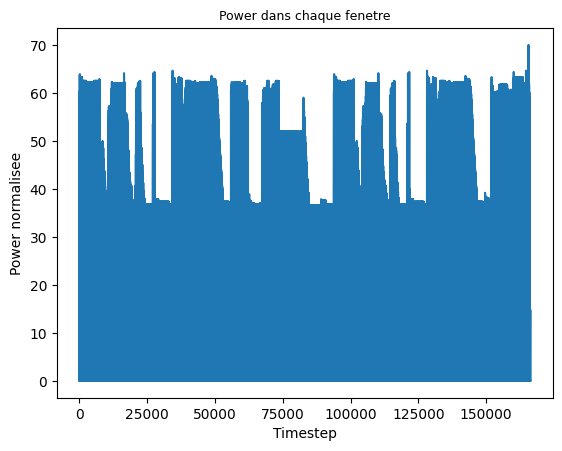

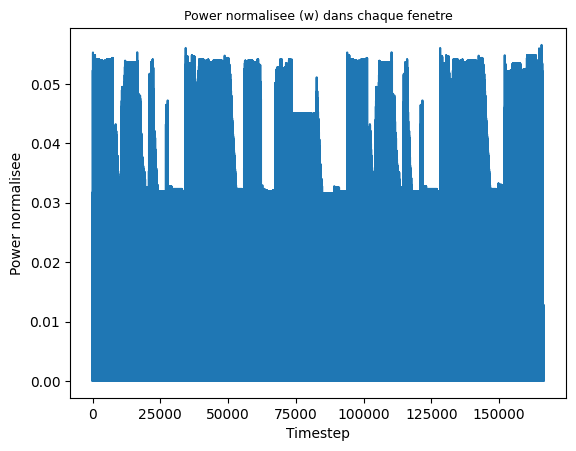

,oc1,oc2,oc3,p1,p2,p3,pt01,pt02,pt03,pt11,pt22,pt33,cl1,cl2,cl3,out,mean,std_window,norm_window
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
rw_dred.shape , rw_dred.shape[0]-3
input_dred, output_dred = utils.slide_window(dataset=rw_dred ,window_size=3)
input_dred = input_dred.squeeze()

new_dred_dataset = np.concatenate((input_dred, np.expand_dims(output_dred, axis=-1)) , axis = 1)

df_dred = pd.DataFrame(new_dred_dataset, columns = ['oc1','oc2','oc3','p1','p2','p3','pt01','pt02','pt03' ,'pt11','pt22','pt33' ,'cl1','cl2','cl3', 'out' ] )

## normalisaons avec le coefficient de variance

df_dred['mean'] = (df_dred['p1'] + df_dred['p2'] + df_dred['p3'] ) / 3 # moyenne des valeurs power pour une window
df_dred['std_window'] = df_dred[['p1' , 'p2' , 'p3']].std(axis=1) # std de P1, P2, P3
df_dred['norm_window'] = ( df_dred['std_window']/(df_dred['mean'] + 1e-7 ) ) * ((df_dred[['p1' , 'p2' , 'p3']].max(axis=1) - df_dred[['p1' , 'p2' , 'p3']].min(axis=1)) /1000) # normalization de P1, P2, P3 

## visualisation

debut = 0
fin   = -1

plt.plot(df_dred['p2'][debut:fin])
plt.xlabel('Timestep')
plt.ylabel("Power normalisee")
plt.title("Power dans chaque fenetre" , {'fontsize': 9}  )
plt.show()
print()

plt.plot(df_dred['norm_window'][debut:fin])
plt.xlabel('Timestep')
plt.ylabel("Power normalisee")
plt.title("Power normalisee (w) dans chaque fenetre" , {'fontsize': 9}  )
plt.show()
print()


df_dred.head(5)

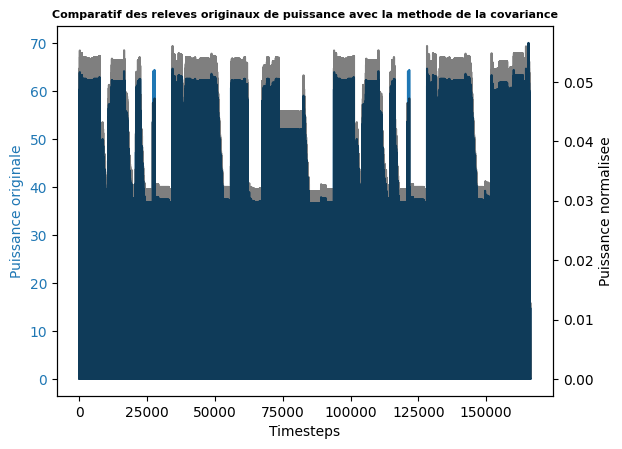

In [14]:
# visuel comparatif (superpose)

debut = 0
fin   = -1

# Creating plot with dataset_1
fig, ax1 = plt.subplots()
 
color = 'tab:blue'
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('Puissance originale', color = color)
ax1.plot(df_dred['p2'][debut:fin], color = color)
ax1.tick_params(axis ='y', labelcolor = color)
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
# color = 'tab:green'
ax2.set_ylabel('Puissance normalisee', color = 'black')
ax2.plot(df_dred['norm_window'][debut:fin], color = 'black', alpha = 0.5)
ax2.tick_params(axis ='y', labelcolor = 'black')
 
# Adding title
plt.title('Comparatif des releves originaux de puissance avec la methode de la covariance', fontsize = 8, fontweight ="bold")
 
# Show plot
plt.show()# Creating plot with dataset_1

In [15]:
# quelques statistiques

df_dred.describe()

,oc1,oc2,oc3,p1,p2,p3,pt01,pt02,pt03,pt11,pt22,pt33,cl1,cl2,cl3,out,mean,std_window,norm_window
count,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000,166350.000000
mean,0.498744,0.498738,0.498738,48.256683,48.256683,48.256683,-0.000141,-0.000141,-0.000141,0.000141,0.000141,0.000141,2.596423,2.596423,2.596423,2.596423,48.256683,1.742082,0.002565
std,0.500000,0.500000,0.500000,15.973123,15.973123,15.973123,10.272110,10.272110,10.272110,10.272110,10.272110,10.272110,1.694745,1.694745,1.694745,1.694745,14.830507,7.054091,0.010594
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-65.004997,-65.004997,-65.004997,-63.869999,-63.869999,-63.869999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,37.330002,37.330002,37.330002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.330002,0.000000,0.000000
50%,0.000000,0.000000,0.000000,52.070000,52.070000,52.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,52.069996,0.000000,0.000000
75%,1.000000,1.000000,1.000000,61.990002,61.990002,61.990002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,4.000000,4.000000,61.990002,0.000000,0.000000
max,1.000000,1.000000,1.000000,70.029999,70.029999,70.029999,63.869999,63.869999,63.869999,65.004997,65.004997,65.004997,4.000000,4.000000,4.000000,4.000000,69.775337,37.627731,0.056587


,oc1,oc2,oc3,p1,p2,p3,pt01,pt02,pt03,pt11,pt22,pt33,cl1,cl2,cl3,out,mean,std_window,norm_window
0,1.0,1.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,1.0,0.0,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.0,1.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,1.0,0.0,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.0,1.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
5,1.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
6,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
7,0.0,0.0,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000
8,0.0,1.0,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,-1.5378,0.0000,0.0000,0.0000,0.0,0.0,1.0,4.0,0.000000,0.000000,0.000000
9,1.0,1.0,0.0,0.0000,0.0000,1.5378,0.0000,-1.5378,0.0000,0.0000,0.0000,1.5378,0.0,1.0,4.0,0.0,0.512600,0.887849,0.002664


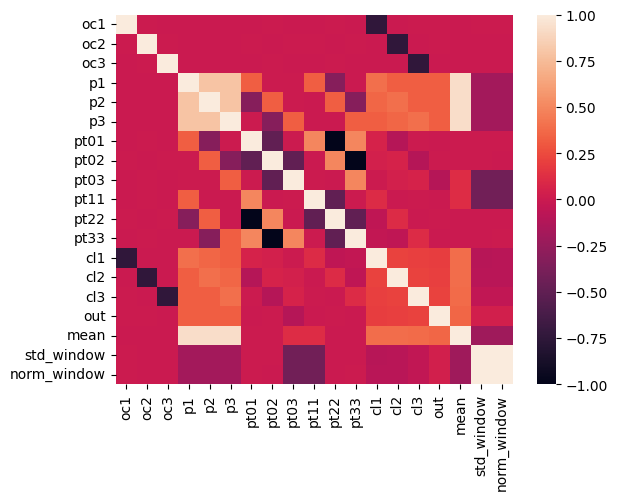

In [46]:
dred_corr = df_dred.corr()
sns.heatmap(dred_corr)
df_dred.head(20)

Models

In [17]:
# Separation en train et test

# dred
dred_feature = df_dred.iloc[ : , 1:-3 ].drop( 'out' , axis = 1 )
dred_target  = df_dred.iloc[ : , 1:-3 ].out

dred_features_train = dred_feature.iloc[ : int(dred_feature.shape[0]*0.8 ) , : ]
dred_features_test  = dred_feature.iloc[ int(dred_feature.shape[0]*0.8 ) : , : ]  

dred_target_train = dred_target.iloc[ : int(dred_feature.shape[0]*0.8 ) ]
dred_target_test  = dred_target.iloc[ int(dred_feature.shape[0]*0.8 ) : ]  




# qud
qud_feature = df_qud.iloc[ : , 1:-3 ].drop( 'out' , axis = 1 )
qud_target  = df_qud.iloc[ : , 1:-3 ].out

qud_features_train = qud_feature.iloc[ : int(qud_feature.shape[0]*0.8 ) , : ]
qud_features_test  = qud_feature.iloc[ int(qud_feature.shape[0]*0.8 ) : , : ]  

qud_target_train = qud_target.iloc[ : int(qud_feature.shape[0]*0.8 ) ]
qud_target_test  = qud_target.iloc[ int(qud_feature.shape[0]*0.8 ) : ]  



In [18]:
# qud
score_qud_cov = {}

xgb_baseline_qud = XGBClassifier()


xgb_baseline_qud.fit(qud_features_train, qud_target_train)
yhat = xgb_baseline_qud.predict(qud_features_test)

score_qud_cov['micro'] =  f1_score(qud_target_test, yhat, average = None)
print(f"Les scores de chaque classe: \n{score_qud_cov['micro']}")

print()
score_qud_cov['macro'] = f1_score(qud_target_test, yhat, average = "macro")
print(f"Les scores de ENSEMBLE classe: \n{score_qud_cov['macro']}")

Les scores de chaque classe: 
[0.95946626 0.99038462 0.99056604 0.85768501 0.98150134]

Les scores de ENSEMBLE classe: 
0.9559206533875264


In [19]:
# dred
score_dred_cov = {}

xgb_baseline_dred = XGBClassifier()


xgb_baseline_dred.fit(dred_features_train, dred_target_train)
yhat = xgb_baseline_dred.predict(dred_features_test)

score_dred_cov['micro'] =  f1_score(dred_target_test, yhat, average = None)
print(f"Les scores de chaque classe: \n{score_dred_cov['micro']}")

print()
score_dred_cov['macro'] = f1_score(dred_target_test, yhat, average = "macro")
print(f"Les scores de ENSEMBLE classe: \n{score_dred_cov['macro']}")

Les scores de chaque classe: 
[0.56504791 0.9939302  0.03221083 0.46581367 0.50153646]

Les scores de ENSEMBLE classe: 
0.5117078150410409


### Normalisation avec le stateful pour le ML

In [20]:
# drop de la colonne de la "power normalized"

dred_dropped = rw_dred.drop('Pn', axis=1)
qud_dropped  = rw_qud.drop('Pn', axis=1)

print(dred_dropped.head())
print()
print(qud_dropped.head())

   occupancy    P  P+t1  P-t1  class_state
0          1  0.0   0.0   0.0            0
1          1  0.0   0.0   0.0            0
2          0  0.0   0.0   0.0            0
3          1  0.0   0.0   0.0            0
4          0  0.0   0.0   0.0            0

   occupancy       P    P+t1    P-t1  class_state
0          1    0.00    0.00    0.00            0
1          1    0.00 -166.43    0.00            1
2          1  166.43    0.00  166.43            3
3          1  159.55    0.00    0.00            3
4          1  143.27    0.00    0.00            3


In [21]:
processor = utils.DataProcessing(qud_dropped)
X_qud , y_qud = processor.processing()

Les statistiques du dataset:

---
Les donnees etudiees
La shape des inputs  : (46927, 3, 5)
La shape des outputs : (46927,)
*******************************************



In [22]:
# sns.kdeplot(X_qud[:, 4])
# print(  f"{X_qud[:10,:100]:.6f} ")


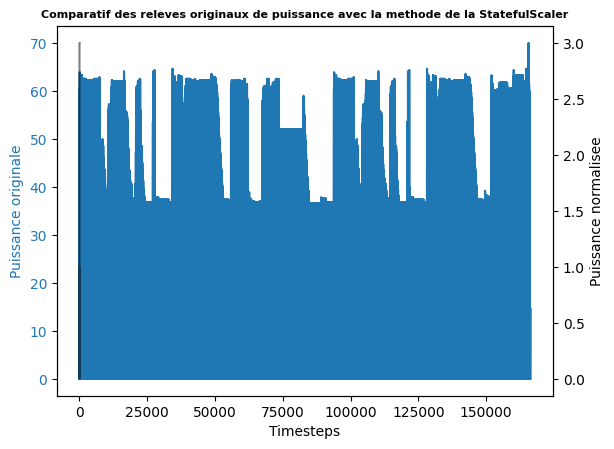

In [23]:
# visuel comparatif (superpose)

debut = 0
fin   = -1

# Creating plot with dataset_1
fig, ax1 = plt.subplots()
 
color = 'tab:blue'
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('Puissance originale', color = color)
ax1.plot(df_dred['p2'][debut:fin], color = color)
ax1.tick_params(axis ='y', labelcolor = color)
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
# color = 'tab:green'
ax2.set_ylabel('Puissance normalisee', color = 'black')
ax2.plot(X_qud[debut:fin][4], color = 'black', alpha = 0.5)
ax2.tick_params(axis ='y', labelcolor = 'black')
 
# Adding title
plt.title('Comparatif des releves originaux de puissance avec la methode de la StatefulScaler', fontsize = 8, fontweight ="bold")
 
# Show plot
plt.show()# Creating plot with dataset_1

In [24]:
processor = utils.DataProcessing(dred_dropped)
X_dred , y_dred = processor.processing()

Les statistiques du dataset:

---
Les donnees etudiees
La shape des inputs  : (166350, 3, 5)
La shape des outputs : (166350,)
*******************************************



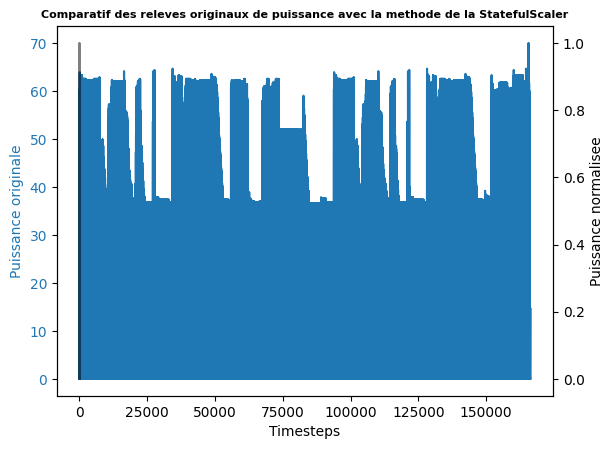

In [25]:
# visuel comparatif (superpose)

debut = 0
fin   = -1

# Creating plot with dataset_1
fig, ax1 = plt.subplots()
 
color = 'tab:blue'
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('Puissance originale', color = color)
ax1.plot(df_dred['p2'][debut:fin], color = color)
ax1.tick_params(axis ='y', labelcolor = color)
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
# color = 'tab:green'
ax2.set_ylabel('Puissance normalisee', color = 'black')
ax2.plot(X_dred[debut:fin][4], color = 'black', alpha = 0.5)
ax2.tick_params(axis ='y', labelcolor = 'black')
 
# Adding title
plt.title('Comparatif des releves originaux de puissance avec la methode de la StatefulScaler', fontsize = 8, fontweight ="bold")
 
# Show plot
plt.show()# Creating plot with dataset_1

Models

In [26]:
# separation des donnees en train et test

# qud

qud_features_train_sf = X_qud[ : int(X_qud.shape[0]*0.8 ) , : ]
qud_features_test_sf  = X_qud[ int(X_qud.shape[0]*0.8 ) : , : ]  

qud_target_train_sf = y_qud[ : int(y_qud.shape[0]*0.8 ) ]
qud_target_test_sf  = y_qud[ int(y_qud.shape[0]*0.8 ) : ]  

print(f"Les donnees de qud")
print(qud_features_train_sf.shape)
print(qud_features_test_sf.shape)
print()
# -----------------------------
print()


# dred
 
dred_features_train_sf = X_dred[ : int(X_dred.shape[0]*0.8 ) , : ]
dred_features_test_sf  = X_dred[ int(X_dred.shape[0]*0.8 ) : , : ]  

dred_target_train_sf = y_dred[ : int(y_dred.shape[0]*0.8 ) ]
dred_target_test_sf  = y_dred[ int(y_dred.shape[0]*0.8 ) : ]  

print(f"Les donnees de dred")
print(dred_features_train_sf.shape)
print(dred_features_test_sf.shape)



Les donnees de qud
(37541, 15)
(9386, 15)


Les donnees de dred
(133080, 15)
(33270, 15)


In [27]:
# Modele de qud

score_qud_sc = {}

xgb_sf = XGBClassifier()


xgb_sf.fit(qud_features_train_sf, qud_target_train_sf)
yhat = xgb_sf.predict(qud_features_test_sf)


score_qud_sc['micro'] =  f1_score(qud_target_test_sf, yhat, average = None)
print(f"Les scores de chaque classe: \n{score_qud_sc['micro']}")

print()
score_qud_sc['macro'] = f1_score(qud_target_test_sf, yhat, average = "macro")
print(f"Les scores de ENSEMBLE classe: \n{score_qud_sc['macro']}")

Les scores de chaque classe: 
[0.94483352 0.98095238 0.         0.84044082 0.96430923]

Les scores de ENSEMBLE classe: 
0.7461071909841155


In [28]:
# Modele de dred

score_dred_sc = {}

xgb_sf = XGBClassifier()


xgb_sf.fit(dred_features_train_sf, dred_target_train_sf)
yhat = xgb_sf.predict(dred_features_test_sf)


score_dred_sc['micro'] =  f1_score(dred_target_test_sf, yhat, average = None)
print(f"Les scores de chaque classe: \n{score_dred_sc['micro']}")

print()
score_dred_sc['macro'] = f1_score(dred_target_test_sf, yhat, average = "macro")
print(f"Les scores de ENSEMBLE classe: \n{score_dred_sc['macro']}")

Les scores de chaque classe: 
[0.47675115 0.98867925 0.         0.3287792  0.5811227 ]

Les scores de ENSEMBLE classe: 
0.4750664581011873


### Les scores

In [29]:
# Les scores avec la technique du coef de covariance

print(f"DRED  ==> {score_dred_cov}")
print(f"QUD   ==> {score_qud_cov}")

DRED  ==> {'micro': array([0.56504791, 0.9939302 , 0.03221083, 0.46581367, 0.50153646]), 'macro': 0.5117078150410409}
QUD   ==> {'micro': array([0.95946626, 0.99038462, 0.99056604, 0.85768501, 0.98150134]), 'macro': 0.9559206533875264}


In [30]:
# Les scores avec la technique Statefulscaler

print(f"DRED  ==> {score_dred_sc}")
print(f"QUD   ==> {score_qud_sc}")

DRED  ==> {'micro': array([0.47675115, 0.98867925, 0.        , 0.3287792 , 0.5811227 ]), 'macro': 0.4750664581011873}
QUD   ==> {'micro': array([0.94483352, 0.98095238, 0.        , 0.84044082, 0.96430923]), 'macro': 0.7461071909841155}


### Sauvegarde du meilleur model en ML

In [31]:
# avec pickle

path = "C:/Users/georg/OneDrive/Documents/GitHub/CapstoneProjectEnergy/"

filename1 = path + 'Models/baseline_qud1_model.sav'
pickle.dump(xgb_baseline_dred, open(filename1, 'wb'))
print(filename1)

# avec joblib

filename2 = path + 'Models/baseline_dred1_model.sav'
joblib.dump(xgb_baseline_qud, filename2)
print(filename2)

C:/Users/georg/OneDrive/Documents/GitHub/CapstoneProjectEnergy/Models/baseline_qud1_model.sav
C:/Users/georg/OneDrive/Documents/GitHub/CapstoneProjectEnergy/Models/baseline_dred1_model.sav


## Deep Machine Learning

In [32]:
# donnees
## l'on retire la colonne Pn avant de le passer au Generateur

rw_dred_cleaned = rw_dred.drop(['Pn'] , axis=1)
rw_qud_cleaned  = rw_qud.drop(['Pn'] , axis=1)
# print(rw_dred_cleaned.shape)

## dred
dred_train = rw_dred_cleaned[:int(rw_dred_cleaned.shape[0]*0.8)]
dred_test = rw_dred_cleaned[int(rw_dred_cleaned.shape[0]*0.8):]
print(dred_train.head())

## qud
qud_train = rw_qud_cleaned[:int(rw_qud_cleaned.shape[0]*0.8)]
qud_test = rw_qud_cleaned[int(rw_qud_cleaned.shape[0]*0.8):]
print(qud_train.head())

   occupancy    P  P+t1  P-t1  class_state
0          1  0.0   0.0   0.0            0
1          1  0.0   0.0   0.0            0
2          0  0.0   0.0   0.0            0
3          1  0.0   0.0   0.0            0
4          0  0.0   0.0   0.0            0
   occupancy       P    P+t1    P-t1  class_state
0          1    0.00    0.00    0.00            0
1          1    0.00 -166.43    0.00            1
2          1  166.43    0.00  166.43            3
3          1  159.55    0.00    0.00            3
4          1  143.27    0.00    0.00            3


### Avec le StatefulScaler

In [33]:
def create_model(input_shape, output_shape):

  input  = tf.keras.Input( shape = input_shape )
  output = tf.keras.layers.Dense( 128 , activation = "relu" )( input )
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( input )
  lstm   = tf.keras.layers.LSTM(256)( output ) 
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( lstm )
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( output )
  output = tf.keras.layers.Dense(  5  , activation = "softmax" )( output )

  model = tf.keras.Model( inputs= input , outputs= output )

  return model

model_qud_sc = create_model( 
    input_shape = (3, 5), # 3 lectures pour 4 features chacune
    output_shape = 2
 )
model_qud_sc.summary()

print()

model_dred_sc = create_model( 
    input_shape = (3, 5), # 3 lectures pour 4 features chacune
    output_shape = 2
 )
model_dred_sc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 5)]            0         
                                                                 
 dense_1 (Dense)             (None, 3, 256)            1536      
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 659,717
Trainable params: 659,717
Non-trainable

In [34]:
model_qud_sc.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = "categorical_crossentropy",
    metrics = [utils.get_f1, 'accuracy']
)

model_dred_sc.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = "categorical_crossentropy",
    metrics = [utils.get_f1, 'accuracy']
)

In [35]:
#dred

generateur_train = utils.Generateur_sc(dred_train, window_size=3, batch_size=256)
generateur_test = utils.Generateur_sc(dred_test, window_size=3, batch_size=256)

# print((generateur_train[0]))
dred_hist_sc = model_dred_sc.fit(
    x = generateur_train,
    epochs=10,
    validation_data = generateur_test
)

Epoch 1/10
519/519 [==============================] - 17s 27ms/step - loss: 0.6029 - get_f1: 0.7518 - accuracy: 0.7925 - val_loss: 0.5463 - val_get_f1: 0.8879 - val_accuracy: 0.8967
Epoch 2/10
519/519 [==============================] - 13s 25ms/step - loss: 0.4322 - get_f1: 0.8834 - accuracy: 0.8846 - val_loss: 0.4456 - val_get_f1: 0.9003 - val_accuracy: 0.9003
Epoch 3/10
519/519 [==============================] - 13s 26ms/step - loss: 0.4168 - get_f1: 0.8830 - accuracy: 0.8830 - val_loss: 0.4752 - val_get_f1: 0.8767 - val_accuracy: 0.9003
Epoch 4/10
519/519 [==============================] - 13s 26ms/step - loss: 0.4209 - get_f1: 0.8843 - accuracy: 0.8850 - val_loss: 0.4145 - val_get_f1: 0.9003 - val_accuracy: 0.9003
Epoch 5/10
519/519 [==============================] - 15s 28ms/step - loss: 0.4111 - get_f1: 0.8864 - accuracy: 0.8870 - val_loss: 0.4095 - val_get_f1: 0.8973 - val_accuracy: 0.8978
Epoch 6/10
519/519 [==============================] - 15s 29ms/step - loss: 0.3956 - get_f

In [36]:
#qud

generateur_train = utils.Generateur_sc(qud_train, window_size=3, batch_size=256)
generateur_test = utils.Generateur_sc(qud_test, window_size=3, batch_size=256)

# print((generateur_train[0]))
qud_hist_sc = model_qud_sc.fit(
    x = generateur_train,
    epochs=10,
    validation_data = generateur_test
)

Epoch 1/10
146/146 [==============================] - 7s 31ms/step - loss: 0.8301 - get_f1: 0.6716 - accuracy: 0.8058 - val_loss: 0.6725 - val_get_f1: 0.8142 - val_accuracy: 0.8164
Epoch 2/10
146/146 [==============================] - 4s 28ms/step - loss: 0.6169 - get_f1: 0.8423 - accuracy: 0.8543 - val_loss: 0.6827 - val_get_f1: 0.8132 - val_accuracy: 0.8164
Epoch 3/10
146/146 [==============================] - 4s 27ms/step - loss: 0.5845 - get_f1: 0.8538 - accuracy: 0.8553 - val_loss: 0.6697 - val_get_f1: 0.8153 - val_accuracy: 0.8164
Epoch 4/10
146/146 [==============================] - 4s 27ms/step - loss: 0.5699 - get_f1: 0.8541 - accuracy: 0.8550 - val_loss: 0.6810 - val_get_f1: 0.8162 - val_accuracy: 0.8164
Epoch 5/10
146/146 [==============================] - 4s 27ms/step - loss: 0.5692 - get_f1: 0.8548 - accuracy: 0.8550 - val_loss: 0.6919 - val_get_f1: 0.8140 - val_accuracy: 0.8160
Epoch 6/10
146/146 [==============================] - 4s 26ms/step - loss: 0.5643 - get_f1: 0.8

In [37]:
# Les scores avec la technique du stateful scaler

dred_score_sc = np.max(dred_hist_sc.history["val_get_f1"])
qud_score_sc  = np.max(qud_hist_sc.history["val_get_f1"])

print(f"DRED  ==> {dred_score_sc}")
print(f"QUD   ==> {qud_score_sc}")

DRED  ==> 0.9002543091773987
QUD   ==> 0.8161736726760864


### Avec le Coef de variance

In [38]:
def create_model(input_shape, output_shape):

  input  = tf.keras.Input( shape = input_shape )
  output = tf.keras.layers.Dense( 128 , activation = "relu" )( input )
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( input )
  lstm   = tf.keras.layers.LSTM(256)( output ) 
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( lstm )
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( output )
  output = tf.keras.layers.Dense(  5  , activation = "softmax" )( output )

  model = tf.keras.Model( inputs= input , outputs= output )

  return model

model_qud_cv = create_model( 
    input_shape = (1, 5), # 3 lectures pour 4 features chacune
    output_shape = 2
 )
model_qud_cv.summary()

print()

model_dred_cv = create_model( 
    input_shape = (1, 5), # 3 lectures pour 4 features chacune
    output_shape = 2
 )
model_dred_cv.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 5)]            0         
                                                                 
 dense_11 (Dense)            (None, 1, 256)            1536      
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dense_14 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 659,717
Trainable params: 659,717
Non-trainab

In [39]:
model_qud_cv.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = "categorical_crossentropy",
    metrics = [utils.get_f1, 'accuracy']
)
model_dred_cv.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = "categorical_crossentropy",
    metrics = [utils.get_f1, 'accuracy']
)

In [40]:
#dred

generateur_train = utils.Generateur_cv(dred_train, window_size=3, batch_size=256)
generateur_test = utils.Generateur_cv(dred_test, window_size=3, batch_size=256)

# print((generateur_train[0]))
dred_hist_cv = model_dred_cv.fit(
    x = generateur_train,
    epochs=10,
    validation_data = generateur_test
)

Epoch 1/10
519/519 [==============================] - 27s 46ms/step - loss: 0.6219 - get_f1: 0.7536 - accuracy: 0.7903 - val_loss: 0.4531 - val_get_f1: 0.8898 - val_accuracy: 0.8898
Epoch 2/10
519/519 [==============================] - 24s 46ms/step - loss: 0.4330 - get_f1: 0.8823 - accuracy: 0.8830 - val_loss: 0.4425 - val_get_f1: 0.8960 - val_accuracy: 0.8956
Epoch 3/10
519/519 [==============================] - 24s 46ms/step - loss: 0.4169 - get_f1: 0.8839 - accuracy: 0.8844 - val_loss: 0.4067 - val_get_f1: 0.9003 - val_accuracy: 0.9003
Epoch 4/10
519/519 [==============================] - 25s 47ms/step - loss: 0.4198 - get_f1: 0.8793 - accuracy: 0.8824 - val_loss: 0.4192 - val_get_f1: 0.8982 - val_accuracy: 0.8982
Epoch 5/10
519/519 [==============================] - 37s 70ms/step - loss: 0.4101 - get_f1: 0.8834 - accuracy: 0.8839 - val_loss: 0.4225 - val_get_f1: 0.9003 - val_accuracy: 0.9003
Epoch 6/10
519/519 [==============================] - 42s 80ms/step - loss: 0.4085 - get_f

In [41]:
#qud

generateur_train = utils.Generateur_cv(dred_train, window_size=3, batch_size=256)
generateur_test = utils.Generateur_cv(dred_test, window_size=3, batch_size=256)

# print((generateur_train[0]))
qud_hist_cv = model_qud_cv.fit(
    x = generateur_train,
    epochs=10,
    validation_data = generateur_test
)

Epoch 1/10
519/519 [==============================] - 47s 81ms/step - loss: 0.6088 - get_f1: 0.7579 - accuracy: 0.7900 - val_loss: 0.4371 - val_get_f1: 0.9003 - val_accuracy: 0.9003
Epoch 2/10
519/519 [==============================] - 41s 78ms/step - loss: 0.4323 - get_f1: 0.8850 - accuracy: 0.8851 - val_loss: 0.4633 - val_get_f1: 0.9003 - val_accuracy: 0.9003
Epoch 3/10
519/519 [==============================] - 42s 81ms/step - loss: 0.4181 - get_f1: 0.8802 - accuracy: 0.8818 - val_loss: 0.4899 - val_get_f1: 0.8660 - val_accuracy: 0.8838
Epoch 4/10
519/519 [==============================] - 41s 80ms/step - loss: 0.4129 - get_f1: 0.8852 - accuracy: 0.8856 - val_loss: 0.4398 - val_get_f1: 0.8977 - val_accuracy: 0.9003
Epoch 5/10
519/519 [==============================] - 42s 80ms/step - loss: 0.4091 - get_f1: 0.8837 - accuracy: 0.8860 - val_loss: 0.3964 - val_get_f1: 0.8976 - val_accuracy: 0.8975
Epoch 6/10
519/519 [==============================] - 41s 79ms/step - loss: 0.4032 - get_f

In [42]:
# Les scores avec la technique du coef de covariance

dred_score_cv = np.max(dred_hist_cv.history["val_get_f1"])
qud_score_cv  = np.max(qud_hist_cv.history["val_get_f1"])

print(f"DRED  ==> {dred_score_cv}")
print(f"QUD   ==> {qud_score_cv}")

DRED  ==> 0.9002543091773987
QUD   ==> 0.9002543091773987


In [43]:
# Les scores avec la technique du coef de covariance

dred_score_cv = np.argmax(dred_hist_cv.history["val_get_f1"])
qud_score_cv  = np.argmax(qud_hist_cv.history["val_get_f1"])

print(f"DRED  ==> {dred_score_cv}")
print(f"QUD   ==> {qud_score_cv}")

DRED  ==> 2
QUD   ==> 0


### Scores en DML

In [44]:
# Les scores avec la technique du stateful scaler

dred_score_sc = np.max(dred_hist_sc.history["val_get_f1"])
qud_score_sc  = np.max(qud_hist_sc.history["val_get_f1"])

print(f"DRED  ==> {dred_score_sc}")
print(f"QUD   ==> {qud_score_sc}")

DRED  ==> 0.9002543091773987
QUD   ==> 0.8161736726760864


In [45]:
# Les scores avec la technique du coef de covariance

dred_score_cv = np.max(dred_hist_cv.history["val_get_f1"])
qud_score_cv  = np.max(qud_hist_cv.history["val_get_f1"])

print(f"DRED  ==> {dred_score_cv}")
print(f"QUD   ==> {qud_score_cv}")

DRED  ==> 0.9002543091773987
QUD   ==> 0.9002543091773987
